# Encoder-Decoder архитектура на основе RNN для сортировки массива

> Написать Encoder-Decoder архитектуру (основанную на RNN/LSTM/Transformer) для задачи сортировки чисел, используя только стандартную библиотеку Python, NumPy и библиотеки для построения графиков, если это необходимо (главным образом, не использовать различные DL фреймворки (ни Tensorflow, ни PyTorch, ни даже Keras) и библиотеки для автоматического дифференцирования). А также проверить корректность Вашей модели с помощью написанного Вами Gradient Checker'а. Обучите модель, приведите пример критерия качества для данной модели. 

В качестве `Encoder-Decoder` архитектуры была выбранная простейшая архитектура на основе `RNN`, которая имеет следующий вид

![](encoder-decoder.png)

На данный момент нужно указывать размер последовательности, которая подается на вход Encoder'у и которую надо генерировать Decoder'у.

Обучим модель, в качестве входных значений ($x^{<1>}$, $x^{<2>}$ и так далее) будем использовать `one-hot-vectors` для чисел. 
Выходные значения ($y^{<1>}$, $y^{<2>}$ и так далее) -- векторы длины "количество чисел", к которым будет применяться `softmax`, а потом считаться `cross-entropy loss`.

В качестве метрики качества будем использовать `accuracy` (долю совпавших элементов). Данная метрика далеко не идеальна, потому что не учитывает, насколько мы ошиблись на каждой позиции, но в качестве начального приближения подходит, так как все-таки позволяет понять, что происходит.

In [1]:
from tensor import Tensor
from net import RNNSortingNet
from one_hot_encoding import one_hot_encoding
from cross_entropy import CrossEntropyLoss
from optimizers import SGD
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SEQ_LEN = 10 # Длина последовательно (размер массива)
INPUT_SIZE = MAX_NO = 20 # Множество значений элементов массива, то есть [0, 20)
HIDDEN_SIZE = 100 # Размер вектора-состояния
EPOCH_COUNT = 10_000
BATCH_SIZE = 32

In [3]:
def output_array(outputs: List[Tensor]) -> np.ndarray:
    result = []

    for output in outputs:
        result.append(output.data.argmax())

    return np.array(result)

In [4]:
def generate_input_sample() -> Tuple[List[Tensor], np.ndarray]:
    X = []
    permutation = np.random.randint(MAX_NO, size=SEQ_LEN)
    target = np.sort(permutation)

    for element in permutation:
        X.append(one_hot_encoding(element, INPUT_SIZE))
        
    return X, target

In [5]:
VAL_SIZE = 50
X_val, y_val = [], []
for _ in range(VAL_SIZE):
    X, y = generate_input_sample()
    X_val.append(X)
    y_val.append(y)

In [6]:
def eval_accuracy(model, X_val, y_val):
    accuracy = 0.0
    for i, X in enumerate(X_val):
        outputs = model(X)
        result_seq = output_array(outputs)
        accuracy += np.sum(result_seq == y_val[i]) / SEQ_LEN
    
    return accuracy / len(X_val)

In [7]:
net = RNNSortingNet(INPUT_SIZE, HIDDEN_SIZE, SEQ_LEN)
optimizer = SGD(net.parameters, lr=0.01)
loss_function = CrossEntropyLoss()

accuracies, loses = [], []

for epoch in range(EPOCH_COUNT):
    optimizer.zero_grad()
    sum_loss = 0.
        
    for batch in range(BATCH_SIZE):
        X, target = generate_input_sample()
        outputs = net(X)
        loss = loss_function(outputs, target)
        loss.backward()

        result_seq = output_array(outputs)
        sum_loss += loss.data
        
        for param in net.parameters:
            param.grad = param.grad / BATCH_SIZE

        optimizer.step()
        
    if epoch % 100 == 0:
        acc = eval_accuracy(net, X_val, y_val)
        mean_loss = sum_loss[0, 0] / BATCH_SIZE
        print(f'Epoch: {epoch}, mean loss: {mean_loss}')
        print(f'Mean accuracy: {acc}')
        accuracies.append(acc) 
        loses.append(mean_loss)

Epoch: 0, mean loss: 30.369896790419943
Mean accuracy: 0.062
Epoch: 100, mean loss: 22.489655206935804
Mean accuracy: 0.19199999999999992
Epoch: 200, mean loss: 21.7626944198911
Mean accuracy: 0.19799999999999993
Epoch: 300, mean loss: 22.63910525906617
Mean accuracy: 0.20999999999999994
Epoch: 400, mean loss: 22.504492323349066
Mean accuracy: 0.20199999999999999
Epoch: 500, mean loss: 21.706971593175513
Mean accuracy: 0.18799999999999994
Epoch: 600, mean loss: 19.116946099182055
Mean accuracy: 0.24199999999999997
Epoch: 700, mean loss: 18.62956425724203
Mean accuracy: 0.278
Epoch: 800, mean loss: 17.48435505907417
Mean accuracy: 0.30800000000000005
Epoch: 900, mean loss: 16.490171583369577
Mean accuracy: 0.30599999999999994
Epoch: 1000, mean loss: 15.893351634520965
Mean accuracy: 0.2879999999999999
Epoch: 1100, mean loss: 15.342967841544029
Mean accuracy: 0.32599999999999996
Epoch: 1200, mean loss: 17.466794571646552
Mean accuracy: 0.31800000000000006
Epoch: 1300, mean loss: 15.35362

Можем увидеть, что обучение есть, `loss` падает, а `accuracy` постепенно растет.

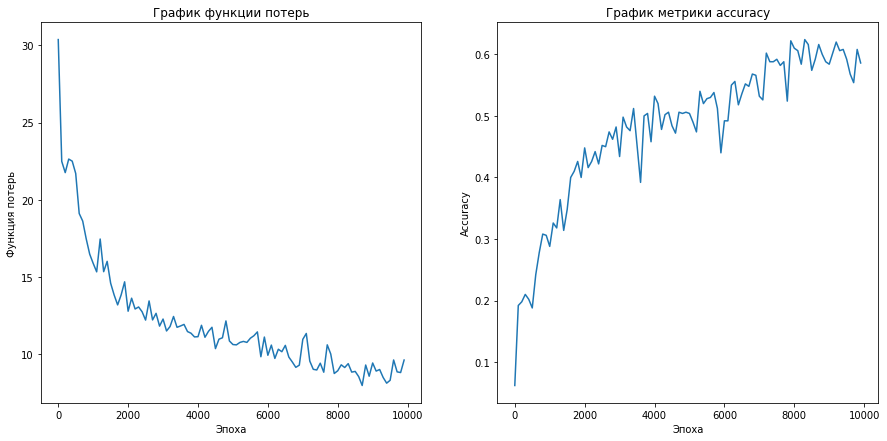

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
x = np.arange(0, EPOCH_COUNT, 100)
ax1.plot(x, loses)
ax1.set_title('График функции потерь')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Функция потерь')

ax2.plot(x, accuracies)
ax2.set_title('График метрики accuracy')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy');

Сгенерируем себе 10 примеров, чтобы посмотреть, что получилось
- `Original` -- перестановка (входные данные)
- `Sorted` -- отсортированная перестановка
- `Net output` -- результат работы нейронной сети на `Original`

In [13]:
for i in range(10):
    X = []
    permutation = np.random.randint(MAX_NO, size=SEQ_LEN)
    target = np.sort(permutation)

    for element in permutation:
        X.append(one_hot_encoding(element, INPUT_SIZE))
        
    outputs = net(X)
    result_seq = output_array(outputs)
    
    print(f'Example {i + 1}:')
    print(f'{permutation} <--- Original')
    print(f'{target} <--- Sorted')
    print(f'{result_seq} <--- Net output')
    print()

Example 1:
[11  8 19  7 14 16  8 14 13 15] <--- Original
[ 7  8  8 11 13 14 14 15 16 19] <--- Sorted
[ 6  7  9 10 13 14 14 15 16 17] <--- Net output

Example 2:
[18  7  8  4  7 11  2  4  9 19] <--- Original
[ 2  4  4  7  7  8  9 11 18 19] <--- Sorted
[ 2  3  5  6  7  7  9 10 17 19] <--- Net output

Example 3:
[ 3  6  2  7 12 19  3 10  6 14] <--- Original
[ 2  3  3  6  6  7 10 12 14 19] <--- Sorted
[ 2  3  3  5  6  7  9 12 14 17] <--- Net output

Example 4:
[ 3 15  4  2  6  6 19 19 10  6] <--- Original
[ 2  3  4  6  6  6 10 15 19 19] <--- Sorted
[ 2  3  4  5  6  7  8 14 17 19] <--- Net output

Example 5:
[13 13  5 10  0  0 12  9 10 15] <--- Original
[ 0  0  5  9 10 10 12 13 13 15] <--- Sorted
[ 0  0  4  8 10 11 12 13 13 14] <--- Net output

Example 6:
[ 8 13  0  8 14 11 10  8  0 14] <--- Original
[ 0  0  8  8  8 10 11 13 14 14] <--- Sorted
[ 0  0  7  8  9 10 12 13 14 15] <--- Net output

Example 7:
[ 7 10  8  7  4  3  2  0  9  3] <--- Original
[ 0  2  3  3  4  7  7  8  9 10] <--- Sorted